In [6]:
import pandas as pd
import configs_py3 as configs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import utilities as utils
from sklearn import linear_model
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch
import os
import skimage.io as io

In [7]:
def get_val_set_labelled():
    
    model = ViltForQuestionAnswering.from_pretrained(configs.CHECKPOINT)
    processor = ViltProcessor.from_pretrained(configs.CHECKPOINT)

    df, train_df, val_df, test_df = utils.load_dataset()

    original_model_outputs = []
 
    softmax_outputs = []
    isRandom_Question = []
    
    for index, row in val_df.head(int(len(val_df)/2)).iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
            
        image = Image.open(imgPath)
        text = row['original_question']
        isRandom_Question.append(0)
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
          
            original_model_outputs.append("N/A")
            softmax_outputs.append(0)
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        softmax_output = softmax_output[0, idx].item()
        softmax_outputs.append(softmax_output)
        
        original_model_outputs.append(model.config.id2label[idx])
        
        
        
        
    
    for index, row in val_df.tail(len(val_df) - int(len(val_df)/2)).iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
            
        image = Image.open(imgPath)
        text = row['random_question']
        isRandom_Question.append(1)
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
          
            original_model_outputs.append("N/A")
            softmax_outputs.append(0)
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        softmax_output = softmax_output[0, idx].item()
        softmax_outputs.append(softmax_output)
        
        original_model_outputs.append(model.config.id2label[idx])
        
        
        
    
    val_df[f'original_model_outputs'] = original_model_outputs
    val_df['softmax_outputs'] = softmax_outputs
    
    val_df['isRandomQuestion'] = isRandom_Question
    
    return val_df

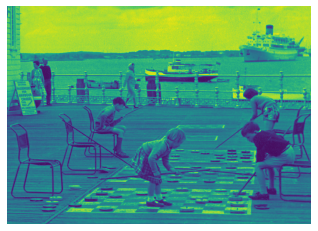

Unsupported number of image dimensions: 2 ==> Skipping this image


In [8]:
val_df =  get_val_set_labelled()

In [9]:
X = np.array(val_df.softmax_outputs).reshape(-1, 1)
Y = np.array(val_df.isRandomQuestion).reshape(-1, 1)

In [10]:
reg = linear_model.LinearRegression()

reg.fit(X, Y)

LinearRegression()

In [13]:
reg

array([[-0.54221771]])

In [11]:
def get_test_set_preds(reg):
    
    model = ViltForQuestionAnswering.from_pretrained(configs.CHECKPOINT)
    processor = ViltProcessor.from_pretrained(configs.CHECKPOINT)

    df, train_df, val_df, test_df = utils.load_dataset()

    original_model_outputs = []
 
    softmax_outputs = []
    isRandom_Question = []
    unrelated_preds = []
    
    for index, row in test_df.iterrows():
        imgId = row['image_id']
        imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
        imgPath = configs.imgDir + imgFilename
        
        if not os.path.isfile(imgPath):
            continue
        
            
        image = Image.open(imgPath)
        text = row['random_question']
        isRandom_Question.append(1)
        # prepare inputs
        try:
            inputs = processor(image, text, return_tensors="pt")
        except Exception as e:
            I = io.imread(imgPath)
        
            plt.imshow(I)
            plt.axis('off')
            plt.show()
            print(e, "==> Skipping this image")
            
            original_model_outputs.append("N/A")
            softmax_outputs.append(0)
            unrelated_preds.append(0)
            continue                
        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        softmax_output = torch.nn.functional.softmax(outputs.logits, dim=1)
        
        
        
        softmax_output = softmax_output[0, idx].item()
        softmax_outputs.append(softmax_output)
        
        isUnrelatedPred = reg.predict([[softmax_output]])
        
        if isUnrelatedPred < 0.5:
            isUnrelatedPred = 0
        else:
            isUnrelatedPred = 1
        
        
        
        
        
        
        original_model_outputs.append(model.config.id2label[idx])
        unrelated_preds.append(isUnrelatedPred)
        
        
        
    
    test_df[f'original_model_outputs'] = original_model_outputs
    test_df['softmax_outputs'] = softmax_outputs
    
    test_df['isRandomQuestion'] = isRandom_Question
    test_df['isUnrelatedPred_linear_reg'] = unrelated_preds
    
    return test_df



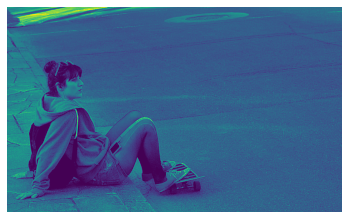

Unsupported number of image dimensions: 2 ==> Skipping this image


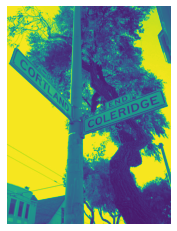

Unsupported number of image dimensions: 2 ==> Skipping this image
0.635


In [12]:
test_df = get_test_set_preds(reg)

print(sum(test_df.isUnrelatedPred_linear_reg)/len(test_df))